In [24]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\NovinAT\AppData\Local\Temp\ipykernel_28924\2120437315.py:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([point[0], proj_point[0]], [point[1], proj_point[1]], 'k--', alpha=0.5,color=color)


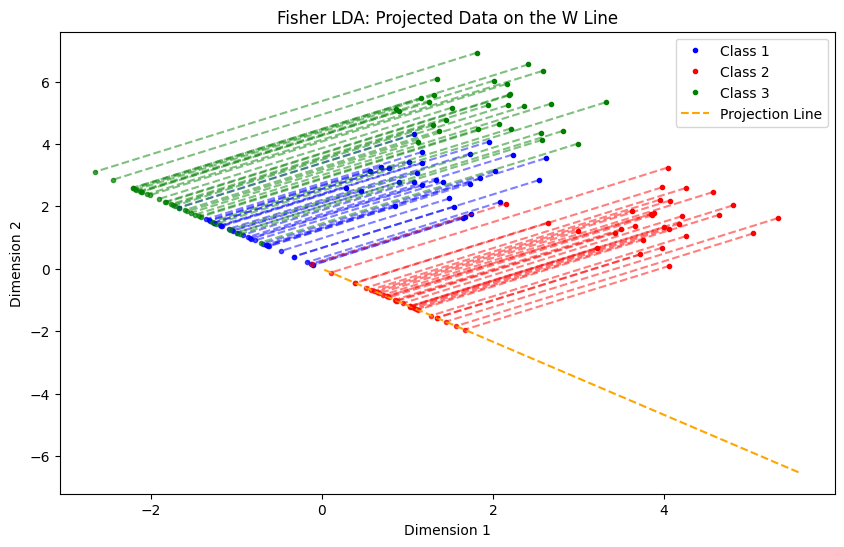

In [32]:

class FisherLDA:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.unique_labels = np.unique(labels)
        self.n_classes = len(self.unique_labels)
        self.means = []
        self.calculate_scatter_matrices()
        self.calculate_projection_vector()
        #self.calculate_class_parameters()

    def calculate_scatter_matrices(self):
        # Compute class means and overall mean
        self.class_means = [self.data[self.labels == cls].mean(axis=0) for cls in self.unique_labels]
        self.overall_mean = self.data.mean(axis=0)

        # Calculate the within-class scatter matrix
        SW = np.zeros((2, 2))
        for cls in self.unique_labels:
            class_data = self.data[self.labels == cls]
            class_scatter = np.cov(class_data.T)
            SW += class_scatter

        # Calculate the between-class scatter matrix
        SB = np.zeros((2, 2))
        for cls, class_mean in zip(self.unique_labels, self.class_means):
            class_data = self.data[self.labels == cls]
            n_class = len(class_data)
            mean_diff = (class_mean - self.overall_mean).reshape(-1, 1)
            SB += n_class * (mean_diff @ mean_diff.T)

        self.SW_inv = np.linalg.inv(SW)
        self.SB = SB

    def calculate_projection_vector(self):
        # Calculate the transformation matrix
        A = self.SW_inv @ self.SB

        # Get the eigenvalues and eigenvectors
        eigen_values, eigen_vectors = np.linalg.eig(A)

        # Select the eigenvector with the highest eigenvalue
        self.best_eigenvector = eigen_vectors[:, np.argmax(eigen_values)]

    def project(self, data):
        return data @ self.best_eigenvector

    # def gaussian(self, X):
    #     means = {}
    #     covariance = {}
    #     priors = {}
    #     for class_id, values in X.items():
    #         proj = np.dot(values, self.best_eigenvector)
    #         means[class_id] = np.mean(proj, axis=0)
    #         covariance[class_id] = np.cov(proj, rowvar=False)
    #         priors[class_id] = len(values) / self.data.shape[0]
    #     return means, covariance, priors

    # def gaussian_distribution(self, x, u, cov):
    #     scalar = (1 / ((2 * np.pi) ** (x.shape[0] / 2))) * (1 / np.sqrt(np.linalg.det(cov)))
    #     x_sub_u = np.subtract(x, u)
    #     return scalar * np.exp(-np.dot(np.dot(x_sub_u, inv(cov)), x_sub_u.T) / 2)

    # def classify(self, X, y):
    #     # Project the data onto the projection vector
    #     proj = self.project(X)
    #     gaussian_likelihoods = []
    #     classes = sorted(list(self.g_means.keys()))

    #     for x in proj:
    #         row = []
    #         for c in classes:
    #             # Compute the Gaussian likelihood
    #             res = self.priors[c] * self.gaussian_distribution(x, self.g_means[c], self.g_covariance[c])
    #             row.append(res)
    #         gaussian_likelihoods.append(row)

    #     # Assign the class with the highest likelihood
    #     gaussian_likelihoods = np.array(gaussian_likelihoods)
    #     predictions = np.argmax(gaussian_likelihoods, axis=1)

    #     # Calculate accuracy
    #     accuracy = np.sum(predictions == y) / len(y)
    #     return predictions, accuracy


# Example use of the FisherLDA class with multi-class data
np.random.seed(42)

# Generate multi-class dataset
class1 = np.random.multivariate_normal((1.5, 3), [[0.5, 0], [0, 0.5]], 30)
class2 = np.random.multivariate_normal((4, 1.5), [[0.5, 0], [0, 0.5]], 30)
class3 = np.random.multivariate_normal((2, 5), [[0.5, 0], [0, 0.5]], 30)

data = np.vstack([class1, class2, class3])
labels = np.array([0] * 30 + [1] * 30 + [2] * 30)

# Initialize Fisher LDA
fisher_lda = FisherLDA(data, labels)

# Create a dictionary with class-wise data
data_by_class = {0: class1, 1: class2, 2: class3}

# # Calculate Gaussian parameters
# fisher_lda.g_means, fisher_lda.g_covariance, fisher_lda.priors = fisher_lda.gaussian(data_by_class)

# Classify with the Fisher LDA projection
projected_data = fisher_lda.project(data)

# Visualize the original data, projection line, and projected data on the W line
plt.figure(figsize=(10, 6))
plt.plot(class1[:, 0], class1[:, 1], 'b.', label='Class 1')
plt.plot(class2[:, 0], class2[:, 1], 'r.', label='Class 2')
plt.plot(class3[:, 0], class3[:, 1], 'g.', label='Class 3')

# Plot the projection line
x_vals = np.array(plt.gca().get_xlim())
y_vals = (x_vals * fisher_lda.best_eigenvector[1] / fisher_lda.best_eigenvector[0])
plt.plot(x_vals, y_vals, '--', color='orange', label='Projection Line')

# Project the original data onto the W line and plot with different colors
for cls, color in zip([class1, class2, class3], ['blue', 'red', 'green']):
    projected_class = fisher_lda.project(cls)
    
    for point, projection in zip(cls, projected_class):
        proj_point = projection * fisher_lda.best_eigenvector  # Point on W
        plt.plot([point[0], proj_point[0]], [point[1], proj_point[1]], 'k--', alpha=0.5,color=color)
        plt.scatter(proj_point[0], proj_point[1], color=color, s=9, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Fisher LDA: Projected Data on the W Line')
plt.legend()
plt.show()

